# Show dependence on activation

In [48]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import seaborn as sns

In [49]:
sys.path.append("..") 
from rcgfd import RCDataset, plot_ke_relerr, MetricsPlot, SingleTimePlot, global_legend

In [50]:
plt.style.use("./rc-gfd.mplstyle")

In [51]:
fig_dir = "../figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [52]:
rcd = RCDataset(
    n_sub=[1, 4, 16],
    cost_terms = [
        {"nrmse": 1},
        #{"nrmse": 1, "spectral": 1e-3},
        {"nrmse": 1, "spectral": 1e-2},
        {"nrmse": 1, "spectral": 1e-1},
    ],
    squeeze=False,
)
ds0 = rcd()

In [53]:
rcd = RCDataset(
    n_sub=[1, 4, 16],
    cost_terms = [
        {"nrmse": 1},
        #{"nrmse": 1, "spectral":1e-3},
        {"nrmse": 1, "spectral":1e-2},
        {"nrmse": 1, "spectral":1e-1},
    ],
    activation="sine",
    squeeze=False,
)
ds = rcd()

In [54]:
ds = xr.concat([ds0,ds], dim="activation")

In [55]:
ds = ds.isel(n_overlap=0, n_reservoir=0)

In [56]:
ds["truth"] = ds["truth"].isel(activation=0)

In [57]:
ds["gamma"] = xr.DataArray([0., 1e-2, 1e-1], coords=ds.experiment.coords, dims=ds.experiment.dims)
ds = ds.swap_dims({"experiment":"gamma"})

In [58]:
#for key in ["truth", "persistence", "p_rmse", "p_nrmse", "p_ke_nrmse", "p_ke_rel_err"]:
#    for d in ["n_reservoir", "n_sub"]:
#        if d in ds[key].dims:
#            ds[key] = ds[key].isel({d:0})

In [59]:
stp = SingleTimePlot(diff_t0=False, time=4*3600)

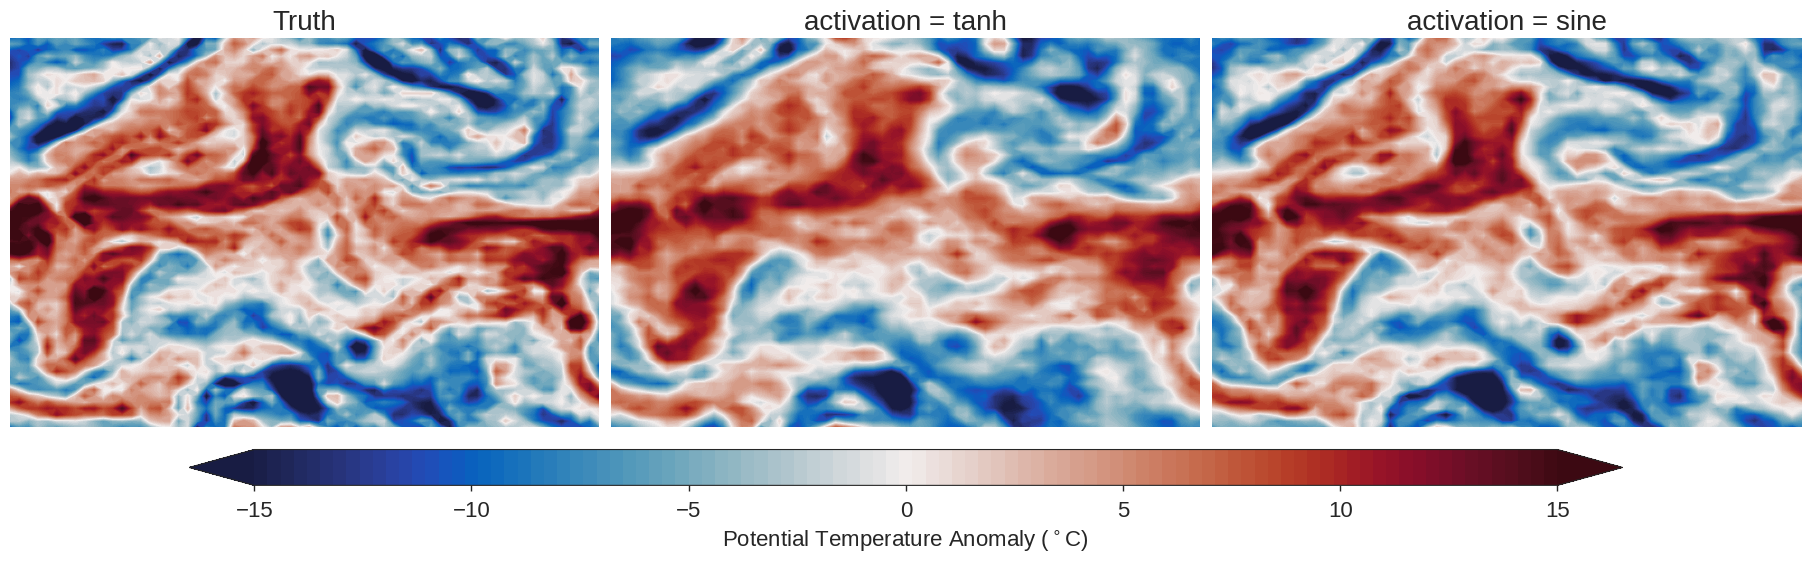

In [60]:
fig, axs = stp(ds.sel(gamma=1e-2, n_sub=4, sample=49), col_dim="activation")
fig.savefig(f"{fig_dir}/rc_tanh_vs_sine_qualitative.jpg", dpi=300)

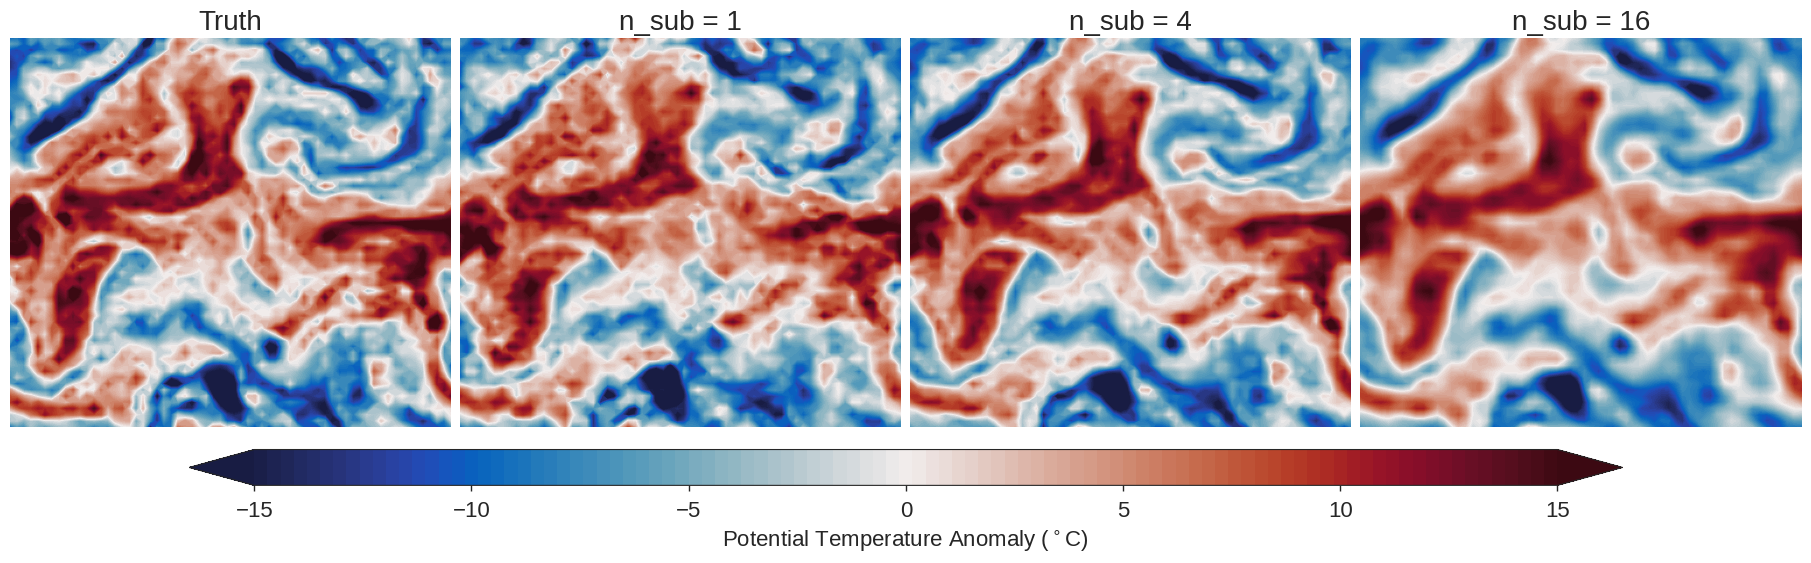

In [61]:
fig, axs = stp(ds.sel(gamma=1e-2, activation='sine', sample=49), col_dim="n_sub")

## Metrics

In [62]:
ds['nrmse'].load();
ds['p_nrmse'].load();

In [63]:
class QuickMetricsPlot(MetricsPlot):
    @property
    def color_start(self):
        return 3

In [64]:
mp = QuickMetricsPlot(
    metrics=("nrmse", "ke_nrmse", "ke_nrmse"),
    cdim="n_sub",
    show_persistence=True,
    estimator="median"
)

In [66]:
def compare_metrics(xds, gamma, plotter=mp, n_sub=16, hue="activation"):
    fig, axs = mp(xds.sel(gamma=gamma), show_time=False, hue=hue, split=True)
    [ax.set(xlabel="$N_{sub}$") for ax in axs[:-1]]
    [ax.legend().remove() for ax in axs]
    axs[1].set(ylim=(0,None))
    axs[-1].clear()
    
    fig, axs = plot_ke_relerr(
        xds["ke_rel_err"].sel(gamma=gamma, n_sub=n_sub),
        fig=fig,
        axs=axs[-1:],
        hours=(4,),
        cdim=hue,
        clabel=lambda a : "a" if hue=="activation" else None,
        show_persistence=True,
        persistence=xds["p_ke_rel_err"],
    )
    if hue == "activation":
        labels = [r"tanh", r"sine", "Persistence"]
    else:
        labels = [r"$\gamma=0$", r"$\gamma=10^{-2}$", "Persistence"]
    global_legend(fig, labels, color_start=mp.color_start)
    return fig, axs

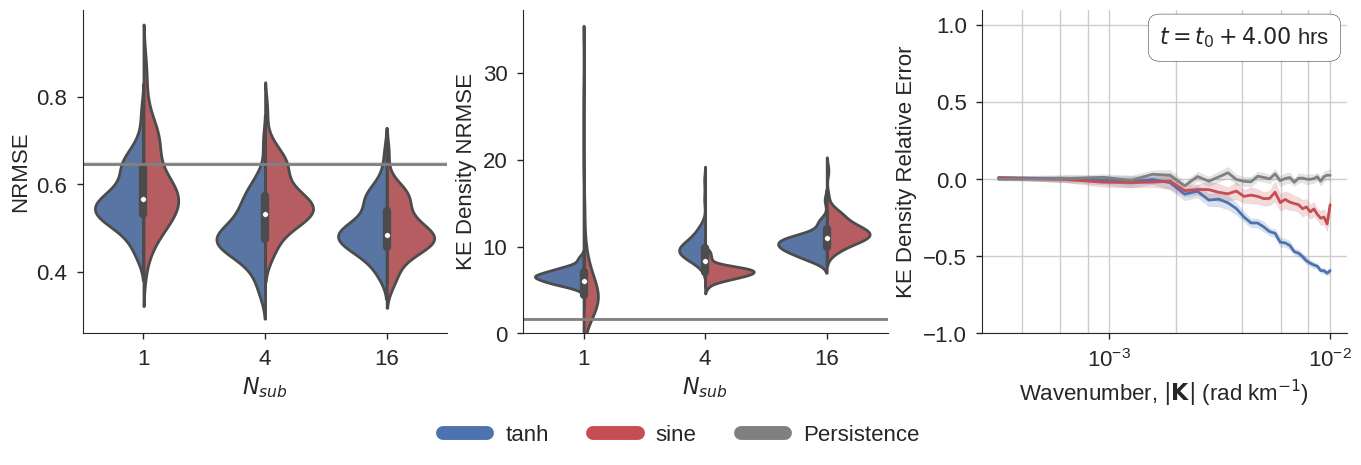

In [67]:
fig, axs = compare_metrics(ds, gamma=1e-2, n_sub=1)
fig.savefig(f"{fig_dir}/rc_tanh_vs_sine_quantitative.pdf", bbox_inches="tight")

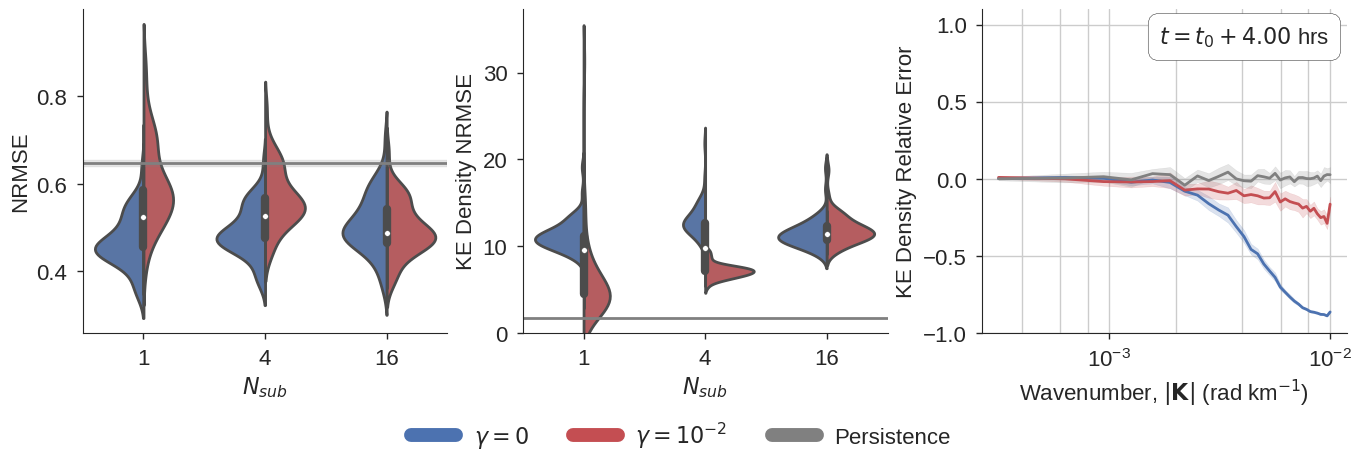

In [69]:
fig, axs = compare_metrics(ds.sel(activation="sine"), gamma=[0, 1e-2], n_sub=1, hue="gamma")
fig.savefig(f"{fig_dir}/rc_sine_gamma_quantitative.pdf", bbox_inches="tight")

(<Figure size 1350x400 with 3 Axes>,
 array([<AxesSubplot: xlabel='Wavenumber, $|\\mathbf{K}|$ (rad km$^{-1}$)', ylabel='KE Density Relative Error'>],
       dtype=object))

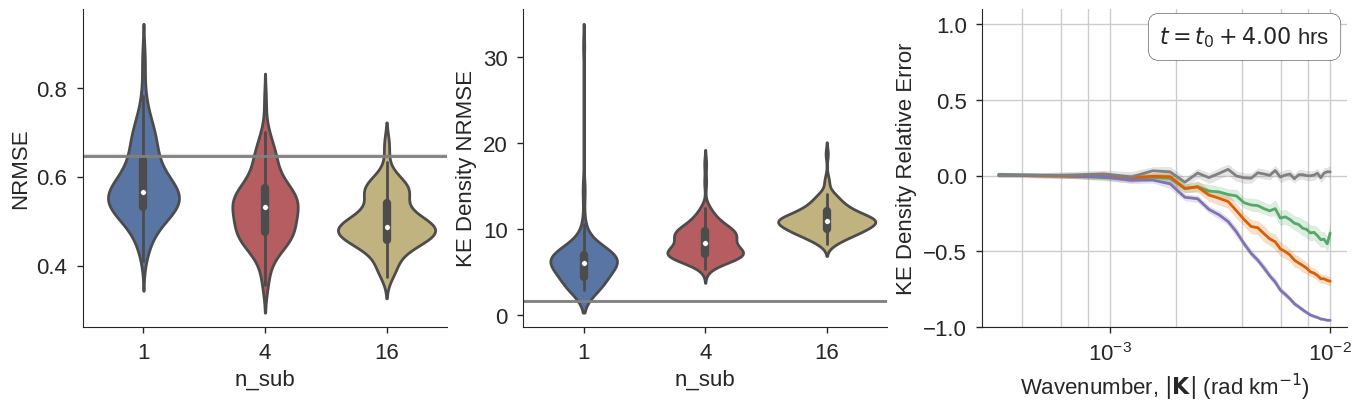

In [33]:
gamma=1e-2
fig, axs = mp(ds.sel(gamma=gamma), show_time=False)
axs[-1].clear()

plot_ke_relerr(
    ds["ke_rel_err"].sel(gamma=gamma),
    fig=fig,
    axs=axs[-1:],
    hours=(4,),
    cdim="n_sub",
    show_persistence=True,
    persistence=ds["p_ke_rel_err"],
)